# Final Report: Crime Rates in Kitsilano & Hastings-Sunrise

## Introduction

Vancouver has always been deemed a relatively safe city; however, crime rates have been increasing in recent years.[2] Though Vancouver is a safe place to live, some neighbourhoods have significantly higher crime rates than other areas. 

In this project, we want to compare the mean crime rates in Kitsilano and Hastings-Sunrise from 2003 to 2022. We will be performing a t-test to compare the difference in mean crime rates over the past 20 years of the two neighbourhoods. The dataset we selected, provided by GeoDASH, is extracted from the PRIME BC Police Records Management System (RMS) and it contains crime data on a year-by-year basis which began in 2003.[1] This data also uses the ‘All Offence’ reporting method along with the condition of ‘Founded’ incidents, which means that the incidents were determined after the police investigation that the violation had occurred.[1]


The variables of interest for us are:

1. <b>TYPE:</b> Type of crime activities
2. <b>YEAR:</b>  Year the criminal activity was reported 
3. <b>NEIGHBOURHOOD:</b> Statistics Canada definition of neighbourhoods within municipalities.

## Methods

We will begin by loading the necessary libraries.

In [2]:
library(tidyverse)
library(repr)
library(digest)
library(infer)
library(gridExtra)
library(taxyvr)
library(cowplot)
library(broom)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




Next, we download the data and display a portion of it in table 1.

In [3]:
# Read the data from the web
crime_data <- read_csv("https://raw.githubusercontent.com/Git-Over-Here/STAT-201-Group-Project/main/combined.csv")


# Display the first 6 rows of raw data
head(crime_data)

Warning message:
“One or more parsing issues, see `problems()` for details”
Rows: 70996 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): TYPE, HUNDRED_BLOCK, NEIGHBOURHOOD
dbl (7): YEAR, MONTH, DAY, HOUR, MINUTE, X, Y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Break and Enter Commercial,2018,5,16,17,0,10XX BOUNDARY RD,Hastings-Sunrise,498275.6,5458125
Break and Enter Commercial,2018,2,27,21,40,11XX ROSSLAND ST,Hastings-Sunrise,496692.0,5458066
Break and Enter Commercial,2012,9,25,22,33,13XX BOUNDARY RD,Hastings-Sunrise,498274.2,5457717
Break and Enter Commercial,2006,5,12,20,0,13XX BOUNDARY RD,Hastings-Sunrise,498274.3,5457739
Break and Enter Commercial,2006,5,13,20,58,13XX BOUNDARY RD,Hastings-Sunrise,498274.3,5457739
Break and Enter Commercial,2006,7,28,18,0,13XX BOUNDARY RD,Hastings-Sunrise,498274.3,5457739


Table 1: Raw Vancouver crime data

As we can see, this data contains lots of information that we are not interested in, so we will select the Neighbourhood and year columns, and remove any entries with NA values in these columns. This tidied data is displayed in table 2.

In [4]:
# Filter out the NAs in the dataset and select the columns we are interested in
filtered_crime <- crime_data %>%
    filter(!is.na(YEAR), !is.na(NEIGHBOURHOOD)) %>%
    select(YEAR, NEIGHBOURHOOD)

# Display first 6 rows of the filtered data
head(filtered_crime)

YEAR,NEIGHBOURHOOD
<dbl>,<chr>
2018,Hastings-Sunrise
2018,Hastings-Sunrise
2012,Hastings-Sunrise
2006,Hastings-Sunrise
2006,Hastings-Sunrise
2006,Hastings-Sunrise


Table 2: Filtered crime data

We are interested in the yearly crime rates for both neighbourhoods, so we find the amount of crimes committed for each combination of neighbourhood and year. Then, in table 3, we display the average of these yearly crime rates for both neighbourhoods. 

In [5]:
# Using the filtered data, find the number of crimes in each year
crime_data <- filtered_crime %>%
    group_by(YEAR, NEIGHBOURHOOD) %>%
    summarize(n = n())

# Using the filtered data, find the number of crimes in each year and find the mean crime rate
crime_data_mean_summary <- crime_data %>%
    group_by(NEIGHBOURHOOD) %>%
    summarize(mean_crime_rate = mean(n))


crime_data_mean_summary

`summarise()` has grouped output by 'YEAR'. You can override using the
`.groups` argument.


NEIGHBOURHOOD,mean_crime_rate
<chr>,<dbl>
Hastings-Sunrise,1466.85
Kitsilano,2082.90


Table 3: Summary of crime data

Using two boxplots, we can display the yearly crime rates for both neighbourhoods.

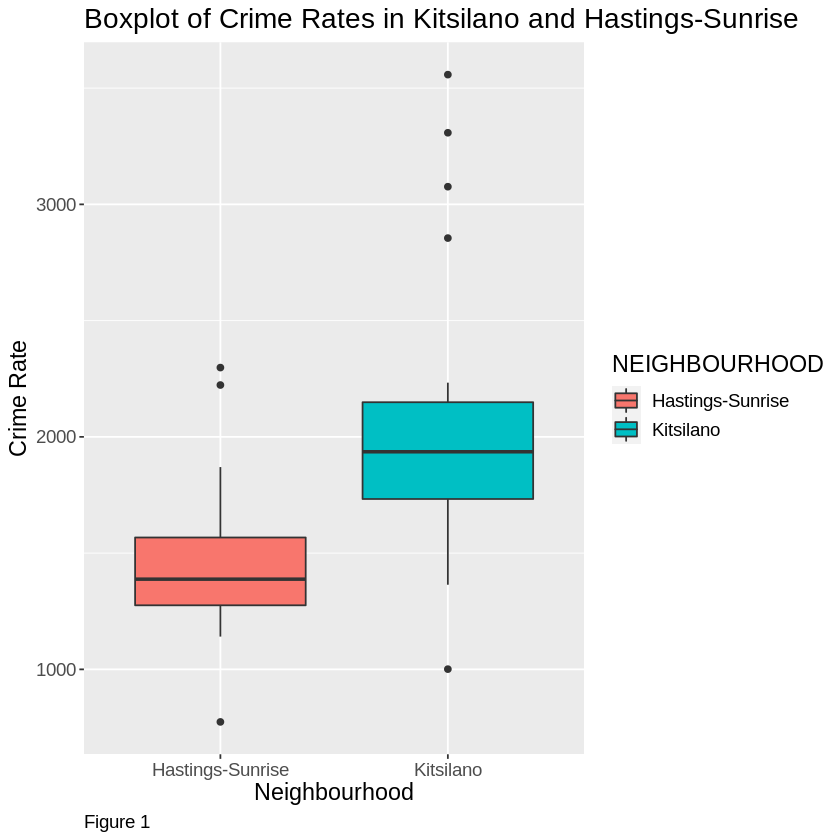

In [6]:
# Plot a boxplot of the crime rates in Kitsilano and Hastings-Sunrise
crime_graph <- crime_data %>% 
    ggplot() +
    geom_boxplot(aes(x = NEIGHBOURHOOD, y = n, fill = NEIGHBOURHOOD)) +
    theme(text = element_text(size = 14), plot.caption = element_text(hjust = 0)) +
    labs(title = "Boxplot of Crime Rates in Kitsilano and Hastings-Sunrise",
    x = "Neighbourhood",
    y = "Crime Rate",
    caption = "Figure 1") +
    guides(scale = "none")
crime_graph

As seen, the median, quartile one and quartile three crime rate values from our data set are all higher for Kitsilano.

We can also display this data using density graphs. We can see a clear distinction in the grouping of these two density lines.

In [7]:
# Plot density curves for yearly crime rates in Kitsilano and Hastings-Sunrise
crime_data_distribution <-
    crime_data %>%
    ggplot() +
    geom_density(aes(x = n, colour = NEIGHBOURHOOD))  +
        theme(text = element_text(size = 14), plot.caption = element_text(hjust = 0)) +
    labs(title = "Distribution of Crime Rates in Kitsilano and Hastings-Sunrise", x = "Yearly Crime Rate", y = "Density", 
         caption = "Figure 2")

options(repr.plot.length = 4, repr.plot.width = 10)


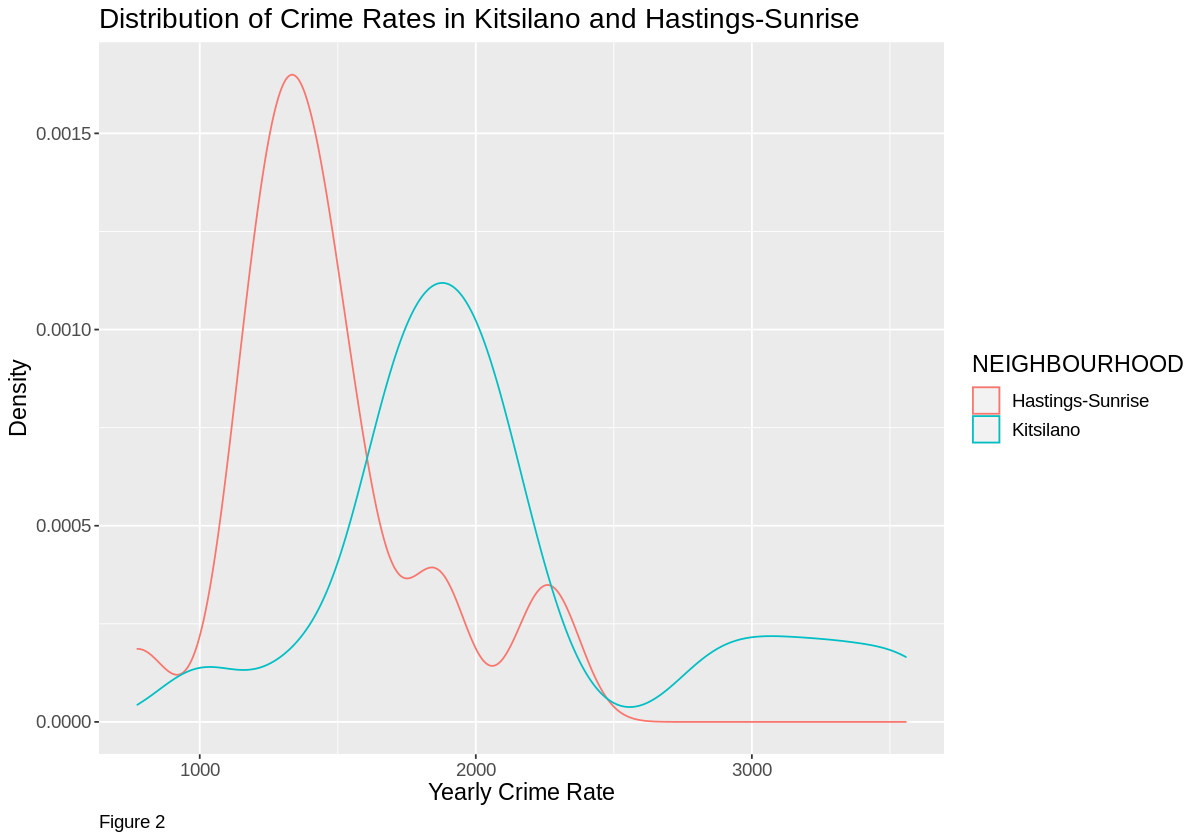

In [8]:
crime_data_distribution

Our hypothesis test is about the mean difference in crime rates between the two neighbourhoods, so for each year, we calculate how much crime was in each neighboorhood. Then we calculate the difference of these values.

In [9]:
# Calculating difference by grouping filtered data by year, calculating the crime rate for each neighbourhood, and taking the difference.
crime_data_difference <- filtered_crime %>%
    group_by(YEAR) %>%
    summarise(Kitsilano = sum(NEIGHBOURHOOD == 'Kitsilano'),
              Hastings_Sunrise = sum(NEIGHBOURHOOD == 'Hastings-Sunrise'),
             Difference = Kitsilano - Hastings_Sunrise)

In [10]:
head(crime_data_difference)

YEAR,Kitsilano,Hastings_Sunrise,Difference
<dbl>,<int>,<int>,<int>
2003,3558,2223,1335
2004,3308,2298,1010
2005,3076,1870,1206
2006,2855,1851,1004
2007,2233,1549,684
2008,2010,1450,560


Table 4: Difference of crime data

A table is not very intuitive to read. We can instead plot the density graph of these differences.

In [11]:
# Now we can use crime_data_difference to plot the distribution of differences
difference_distribution <-
    crime_data_difference %>%
    ggplot() +
    geom_density(aes(x = Difference)) +
        theme(text = element_text(size = 14), plot.caption = element_text(hjust = 0)) +
    labs(title = "Distribution of Difference of Crime Rates Between Kitsilano and Hastings-Sunrise", 
         x = "Difference of Crime Rates By Year",
         y = "Density",
         caption = "Figure 3")

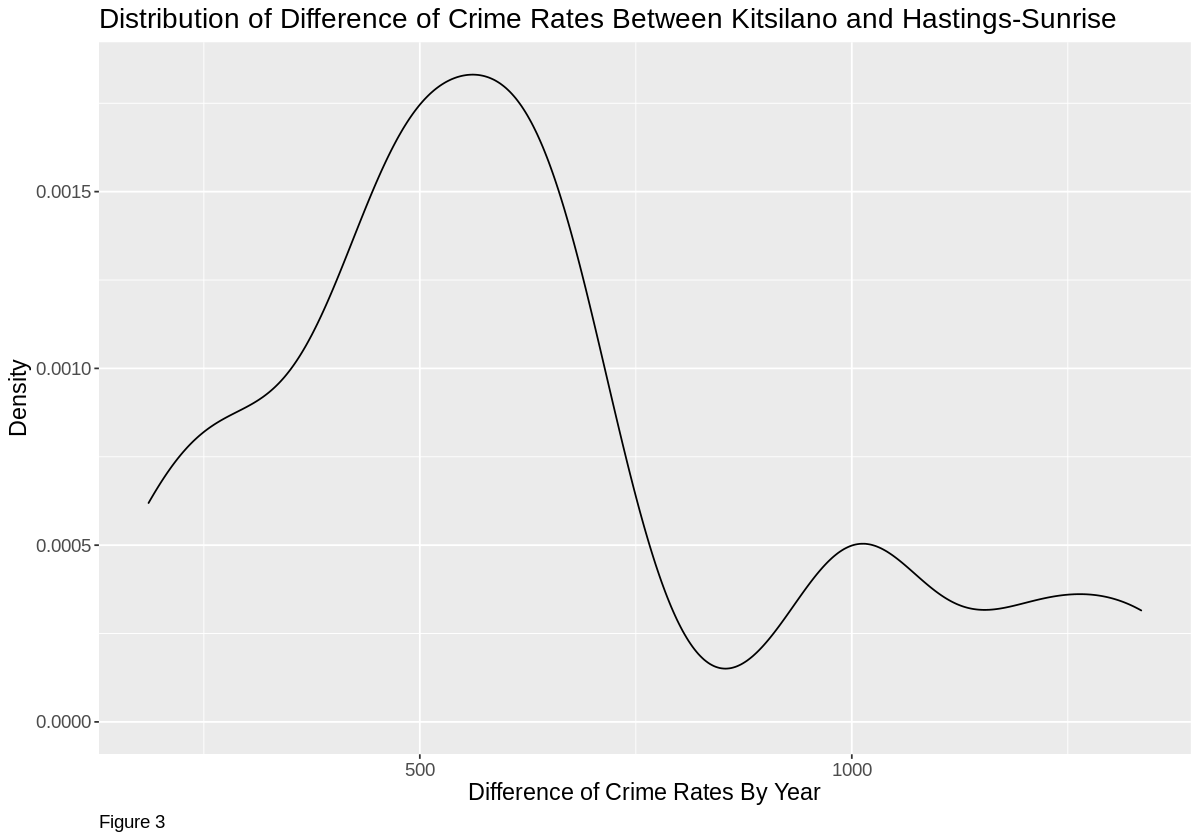

In [12]:
difference_distribution

## Results

### T-test

We will first perform a t test to test our hypothesis. We can do this because the distribution of yearly crime rate differences is approximately normal. We perform the t test using the t.test() function, and we are using a 95% confidence interval. This test is summarised in table 5.

In [13]:
#Performing t-test based on the difference in crime rate found in crime_data_difference
#We use tidy() to make the data more readable and easier to use
t_test <-tidy(
  t.test(x = crime_data_difference$Difference,
         mu = 0,
         alternative = 'two.sided',
         conf.level = 0.95)
)

In [14]:
t_test

estimate,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
616.05,8.909231,3.268904e-08,19,471.3229,760.7771,One Sample t-test,two.sided


Table 5: T test results

We have obtained a very low p-value from this test, since this p-value is below our critical value (0.05), we can reject the null hypothesis at a 95% confidence level. 


To understand how low this p-value is, we can display the test statistic on the appropriate t-distribution graph using the stat_function() from ggplot2 to draw the distribution curve, and using geom_vline to display the test statistic.

In [15]:
#Creation of a graph of the t-distribution with the degrees of freedom based on the t-test 
#Adding a vertical line where our test statistic is
t_graph <- ggplot(data.frame(x = c(-10, 10)), aes(x = x)) +
        stat_function(fun = dt, args = list(df = t_test$parameter)) +
        geom_vline(xintercept = t_test$statistic, colour = 'red') +
        labs(x = 't-score', y = 'Density', title = paste("Student's t-distribution (df =",  t_test$parameter, ")"), 
             subtitle = 'Red line represents test statistic',
             caption = 'Figure 4') +
        theme(text = element_text(size = 14), plot.caption = element_text(hjust = 0))

options(repr.plot.width=8, repr.plot.height=6)

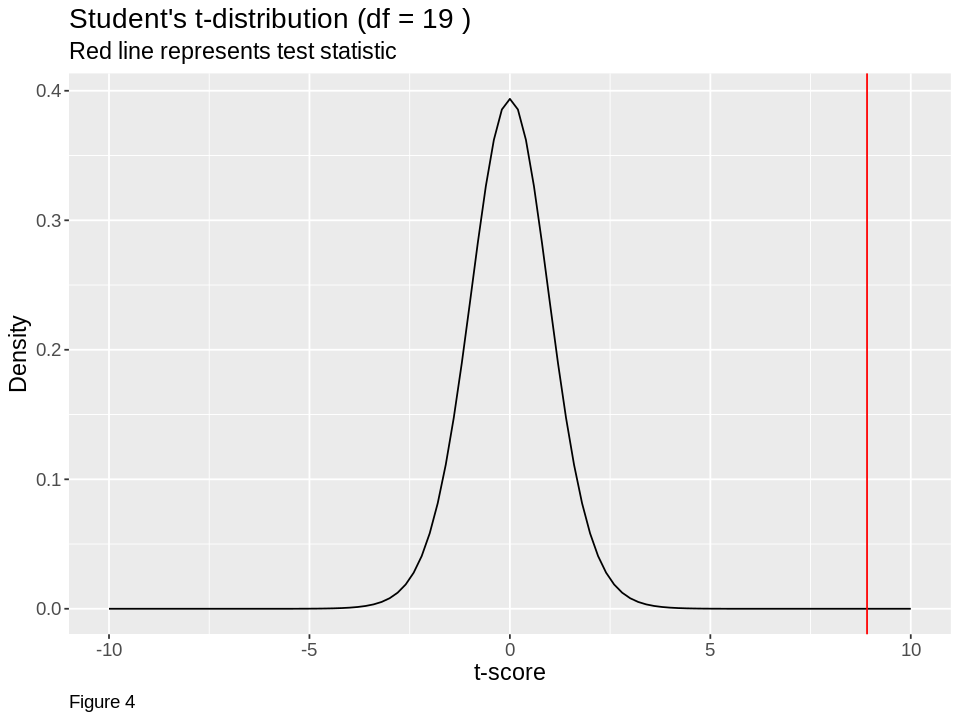

In [16]:
t_graph

### Bootstrap

Next, we will use a bootstrap method to perform our hypothesis test. Using the infer package we can first set up our hypothesis that the mean difference is 0. Next we create 10,000 bootstrap samples, and calculate the mean of each sample. From this distribution of bootstrap samples, we can create a 95% confidence interval using the get_ci() command.

We can then plot the bootstrap distribution as well as the confidence we just calculated, displayed in blue, and the observed mean difference from our original sample.

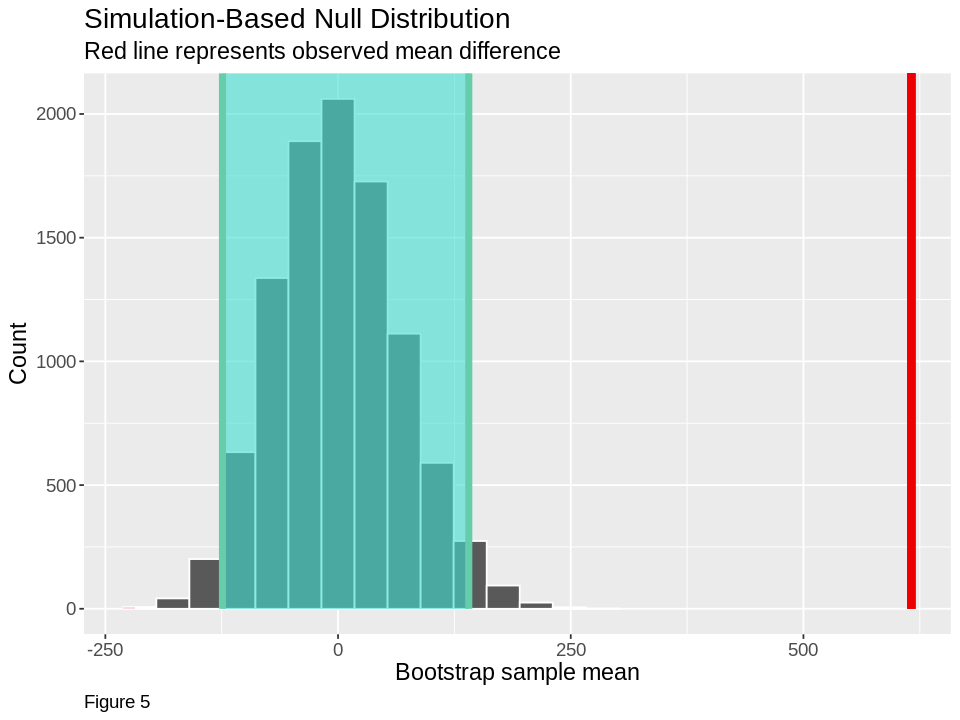

In [17]:
null_model <-
    crime_data_difference %>%
    specify(response = Difference) %>%
    hypothesize(null = 'point', mu = 0) %>%
    generate(reps = 10000, type = 'bootstrap') %>%
    calculate(stat = 'mean')

null_model_ci <- null_model %>%
    get_ci(level = 0.95, type = 'percentile')

visualize(null_model) +
    shade_ci(endpoints = null_model_ci) +
    shade_p_value(obs_stat = mean(crime_data_difference$Difference), direction = 'both') +
    theme(text = element_text(size = 14), plot.caption = element_text(hjust = 0)) +
    labs(caption = 'Figure 5', subtitle = 'Red line represents observed mean difference',
        x = 'Bootstrap sample mean', y = 'Count')

Since our observed statistic is outside of the confidence interval, we can reject the null hypothesis at a 95% confidence level.

As shown in the distributions above, bootstrapping and t-testing yielded similar results. This is due to the use of a huge sample size which will make little to no difference when comparing means. While these two methods perform well, if we were to choose which one was more appropriate than the other, then we would choose the t-test because bootstrapping is very dependent on a sample that represents the population and lacks other assumption advantages which the t-test has. In addition, implementing a t-test is much easier than bootstraping.  

## Discussion

After performing a t-test on our sample, we obtained a p-value of 3.268904e-08 and a test statistic of 8.909231. The results indicated that there is a significant difference in mean crime rates in Kitsilano and Hastings-Sunrise from 2003 to 2022; therefore, we reject our null hypothesis. From our initial results, we find that the mean crime rate is higher in Kitsilano than Hastings-Sunrise. Initially, we hypothesized that Kitsilano will have a lower crime rate than Hastings-Sunrise because Kitsilano has a better reputation in terms of safety compared to Hastings-Sunrise. To our surprise, Hastings-Sunrise actually has a lower mean crime rate in the past 20 years. 

Though crime rates is a key factor determining the safety of a neighborhood, we cannot conclude that Hastings-Sunrise is safer than Kitsilano in our project. In future studies, we can compare the different types of crime in Kitsilano and Hastings-Sunrise as some crimes are more severe than others. 

## References

[1] (2022) VPD open data. Available at: https://geodash.vpd.ca/opendata/# (Accessed: October 25, 2022). 

[2] Daflos, P. (2022) Is Vancouver 'deteriorating'? how public safety is being debated in the lead-up to the election, British Columbia. CTV News. Available at: https://bc.ctvnews.ca/is-vancouver-deteriorating-how-public-safety-is-being-debated-in-the-lead-up-to-the-election-1.6103614 (Accessed: November 2, 2022). 